In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
train_orig = pd.read_csv("train_FE.csv")
test_orig = pd.read_csv("test_FE.csv")

In [18]:
train = train_orig.copy()
test = test_orig.copy()

<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

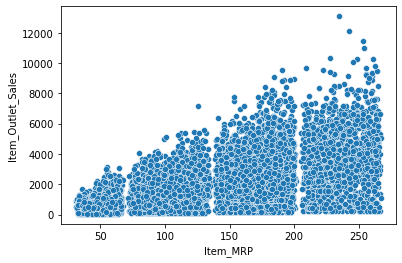

In [19]:
sns.scatterplot(x=train["Item_MRP"],y=train["Item_Outlet_Sales"])

we can observe different rangees of prices
* lets create clusters using kmeans

In [20]:
from sklearn.cluster import KMeans
train_df = train.drop(["Item_Identifier","Outlet_Identifier","Item_Outlet_Sales"],axis=1)
test_df = test.drop(["Item_Identifier","Outlet_Identifier"],axis=1)

kmeans_obj = KMeans(n_clusters=4)
kmeans_obj.fit(train_df)

KMeans(n_clusters=4)

In [21]:
train_df["cluster"] = kmeans_obj.predict(train_df)

In [22]:
test_df["cluster"] = kmeans_obj.predict(test_df)

In [23]:
train_df["Item_Outlet_Sales"] = train["Item_Outlet_Sales"]

<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

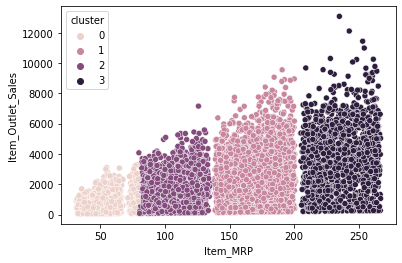

In [65]:
# lets observe the clusters
sns.scatterplot(x=train_df["Item_MRP"],y=train_df["Item_Outlet_Sales"],hue=train_df["cluster"])

In [26]:
def submission_df(predicted_test):
    submission = test_orig[["Item_Identifier","Outlet_Identifier"]]
    submission["Item_Outlet_Sales"]=predicted_test
    return submission

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold,cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
class get_best_model:
    
    def apply_model(self,model,train,test,target_feature,k_splits):
   
        #define predictor and response variables
        x_train=train.drop([target_feature],axis=1)
        y_train = train[[target_feature]]
    
        model.fit(x_train,y_train)
        y_train_pred = model.predict(x_train)
   
        #define cross-validation method to use
        cv = KFold(n_splits=k_splits, random_state=1, shuffle=True) 
        #get the mean square error cv scores
        scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error',cv=cv, n_jobs=-1)
        # get the square root of mean square error cv scores
        scores = np.sqrt(np.abs(scores))
        
        training_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
        cv_avg_rmse = np.mean(scores)
        #print(f"Training RMSE {np.sqrt(mean_squared_error(y_train,y_train_pred))}")
        #print(f"CV  mean = {np.mean(scores)} max = {np.max(scores)} min = {np.min(scores)} std = {np.std(scores)}")
    
        y_test_pred = model.predict(test)

        #print("Number of negative values predicted for training: {},test :{}".format((y_train_pred<0).sum(),(y_test_pred<0).sum()))

        #final_pred_df = submission_df(y_test_pred)
        if (y_train_pred<0).sum()==0 and (y_test_pred<0).sum()==0:
           
            return {"model":model,"cv_score":np.mean(scores)}
        else:
            return None
        
    def test_models(self,train,test,target_feature,k_splits):
        
        models={"DecisionTree":DecisionTreeRegressor(random_state=1),"RandomForest":RandomForestRegressor(random_state=1),
       "supportVector":svm.SVR()}
        
        best_min_score=None
        best_model = None
        for model in models.keys():
            
            result = self.apply_model(models[model],train_df,test_df,"Item_Outlet_Sales",5)
            #print(best_min_score)
            if result is None:
                continue
            else:
                if best_min_score is None:
                    best_min_score = result["cv_score"]
                    #best_model = result["model"]
                    best_model = model
                elif result["cv_score"]<best_min_score:
                    best_min_score = result["cv_score"]
                    #best_model = result["model"]
                    best_model = model
                    
        print(best_model," ",best_min_score)
        return best_model
    

        

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
class Tuning():
    
    def model_params(self,model):
        rf_params = {"n_estimators": [int(x) for x in np.linspace(1,100,10)],
             "criterion" : ["squared_error", "absolute_error", "poisson"],
            "max_depth" : [int(x) for x in np.linspace(1,100,10)],
            "min_samples_split" : [int(x) for x in np.linspace(1,10,5)],
             "max_features":["auto","sqrt","log2"],
            "min_samples_leaf":[int(x) for x in np.linspace(1,10,5)],
            "max_leaf_nodes":[int(x) for x in np.linspace(1,10,5)],
            "max_samples":[x for x in np.linspace(1,10,5)]}

        models_with_params = [("RandomForest",RandomForestRegressor(random_state=1),rf_params)]
        for item in models_with_params:
            if item[0] == model:
                return item
            
   
    def random_search_cv(self,model,params,train,test,target_feature):
        
        #define predictor and response variables
        x_train=train.drop([target_feature],axis=1)
        y_train = train[[target_feature]]
        
        randomcv=RandomizedSearchCV(estimator = model,param_distributions = params,scoring= 'neg_root_mean_squared_error',
                                    n_iter = 100,cv = 3,verbose = 2,random_state=100,n_jobs=-1)
        randomcv.fit(x_train,y_train)
        print(randomcv.best_params_)
        
        #best_model = randomcv.best_estimator_
        #best_model.fit(x_train,y_train)
        #y_pred_test = best_model
        print("best random score" ,randomcv.best_score_)
        return randomcv.best_params_
    
    def get_grid_params(self,best_random_params):
        grid_params={}
        for param in best_random_params.keys():
            if type(best_random_params[param])==str:
                grid_params[param]=[best_random_params[param]]
            elif type(best_random_params[param])==int:
                best_value = best_random_params[param]
                if best_value-10<0:
                    start=0
                else:
                    start = best_value-10
                grid_params[param]=[int(x) for x in range(start,best_value+10,3)]
            elif type(best_random_params[param])==float:
                best_value = best_random_params[param]
                if best_value-10<0:
                    start=0
                else:
                    start = best_value-10
                grid_params[param]=[x for x in np.linspace(start,best_value+10,10)]
        print(grid_params) 
        return grid_params
    
    def grid_search_cv(self,model,params,train,test,target_feature):
        
        #define predictor and response variables
        x_train=train.drop([target_feature],axis=1)
        y_train = train[[target_feature]]
        
        gridcv=GridSearchCV(estimator = model,param_grid = params,scoring= 'neg_root_mean_squared_error',
                                    cv = 3,verbose = 2,n_jobs=-1)
        gridcv.fit(x_train,y_train)
        print(gridcv.best_params_)
        
        #best_model = randomcv.best_estimator_
        #best_model.fit(x_train,y_train)
        #y_pred_test = best_model
        print("best grid score" ,gridcv.best_score_)
        #print(gridcv.best_estimator_)
        return gridcv.best_estimator_
    
    def best_model(self,model,params,train,test,target_feature):
        random_params = self.random_search_cv(model,params,train,test,target_feature)
        grid_params = self.get_grid_params(random_params)
        best_model = self.grid_search_cv(model,grid_params,train,test,target_feature)
        return best_model
    
    

    def get_best_tuned_model_for_cluster(self,model,train,test,target_feature):
        model_name,model_obj,model_params = self.model_params(model)
        best_estimator = self.best_model(model_obj,model_params,train,test,target_feature)
        #print(best_estimator)
        return best_estimator
        

    



In [51]:
# now lets apply the best algorithm for each cluster
grps = train_df.groupby("cluster")
cluster_models={}
#for grp in [0]:
for grp in grps.groups.keys():
    print("started with cluster :",grp)
    train_data = grps.get_group(grp)
    test_data = test_df[test_df["cluster"]==grp]
    
    train_data = train_data.drop("cluster",axis=1)
    test_data = test_data.drop("cluster",axis=1)
    
    
    obj = get_best_model()
    model = obj.test_models(train_data,test_data,"Item_outlet_Sales",5)
    print("best model for the cluster ",grp, ":",model)
    tuning_obj = Tuning()
    print(train_data.shape)
    best_tuned_model = tuning_obj.get_best_tuned_model_for_cluster(model,train_data,test_data,"Item_Outlet_Sales")
    print("best tuned model for the cluster ",grp, ":",model)
    cluster_models["cluster_"+str(grp)] = best_tuned_model


started with cluster : 0
RandomForest   1132.0380419414832
best model for the cluster  0 : RandomForest
(1542, 12)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 23, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_samples': 1.0, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 78, 'criterion': 'squared_error'}
best random score -386.0037117802628
{'n_estimators': [13, 16, 19, 22, 25, 28, 31], 'min_samples_split': [0, 3, 6, 9, 12], 'min_samples_leaf': [0, 3, 6, 9, 12], 'max_leaf_nodes': [0, 3, 6, 9, 12, 15, 18], 'max_features': ['auto'], 'max_depth': [68, 71, 74, 77, 80, 83, 86], 'criterion': ['squared_error']}
Fitting 3 folds for each of 8575 candidates, totalling 25725 fits
{'criterion': 'squared_error', 'max_depth': 68, 'max_features': 'auto', 'max_leaf_nodes': 15, 'min_samples_leaf': 12, 'min_samples_split': 3, 'n_estimators': 19}
best grid score -379.5877759819121
best tuned model for the cluster  0 : RandomForest
started with cluster 

In [52]:
class apply_best_model_cluster:
    def apply_model(self,model,train,test,target_feature,k_splits):
   
        #define predictor and response variables
        x_train=train.drop([target_feature],axis=1)
        y_train = train[[target_feature]]

        model.fit(x_train,y_train)
        y_train_pred = model.predict(x_train)
   
        #define cross-validation method to use
        cv = KFold(n_splits=k_splits, random_state=1, shuffle=True) 
        #get the mean square error cv scores
        scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error',cv=cv, n_jobs=-1)
        # get the square root of mean square error cv scores
        scores = np.sqrt(np.abs(scores))
    
        print(f"Training RMSE {np.sqrt(mean_squared_error(y_train,y_train_pred))}")
        print(f"CV  mean = {np.mean(scores)} max = {np.max(scores)} min = {np.min(scores)} std = {np.std(scores)}")
    
        y_test_pred = model.predict(test)
   
        print("Number of negative values predicted for training: {},test :{}".format((y_train_pred<0).sum(),(y_test_pred<0).sum()))
    
        
   
        return y_test_pred

    def submission_file(self,target_predicted,id_df):
        id_df["Item_Outlet_Sales"] = target_predicted
        return id_df


In [57]:
train["cluster"] = train_df["cluster"]
test["cluster"] = test_df["cluster"]

In [58]:
final_df = pd.DataFrame()
for cluster in [0,1,2,3]:
    train_data = train_df[train_df["cluster"]==cluster]
    test_data = test_df[test_df["cluster"]==cluster]
    
    best_model = cluster_models['cluster_'+str(cluster)]
    obj = apply_best_model_cluster()
    target_pred = obj.apply_model(best_model,train_data,test_data,"Item_Outlet_Sales",5)
    id_df = test[test["cluster"]==cluster][["Item_Identifier","Outlet_Identifier"]]
    
    cluster_final_df = obj.submission_file(target_pred ,id_df )
    if final_df.shape==(0,0):
        final_df = cluster_final_df
    else:
        final_df = pd.concat([final_df,cluster_final_df],axis=0)

Training RMSE 355.041359614133
CV  mean = 384.76921635665366 max = 411.52715486151715 min = 363.3066107604532 std = 18.412990489646315
Number of negative values predicted for training: 0,test :0
Training RMSE 1177.6723780423372
CV  mean = 1192.3267396495278 max = 1239.6518488902325 min = 1132.2755478493873 std = 40.790446317157034
Number of negative values predicted for training: 0,test :0
Training RMSE 726.1987057885116
CV  mean = 774.6225639679675 max = 813.532495578779 min = 722.4928867060324 std = 36.492006353473556
Number of negative values predicted for training: 0,test :0
Training RMSE 1636.7910556576664
CV  mean = 1677.7862100699397 max = 1735.1161834918275 min = 1618.5869897503999 std = 42.76853155213762
Number of negative values predicted for training: 0,test :0


In [59]:
final_df.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
6,FDL48,OUT018,719.341092
14,DRL59,OUT013,740.639431
22,FDG52,OUT046,737.323832
26,NCF19,OUT035,745.725164
30,NCR42,OUT019,130.788398


In [60]:
final_df.to_csv("customised_ml.csv",index=False)

### Your score for this submission is : 1155.1798923256895.

In [44]:
dicti = {"a":1,"b":2}
temp={}
for i in dicti.keys():
    temp["temp_"+i]=dicti[i]

In [45]:
temp

{'temp_a': 1, 'temp_b': 2}

In [47]:
"a1"+str(1)

'a11'

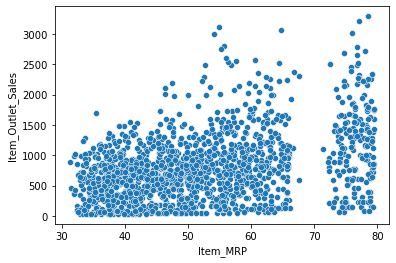

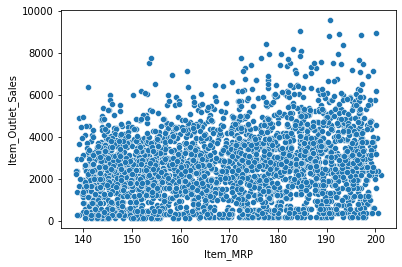

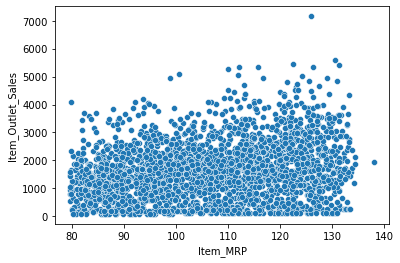

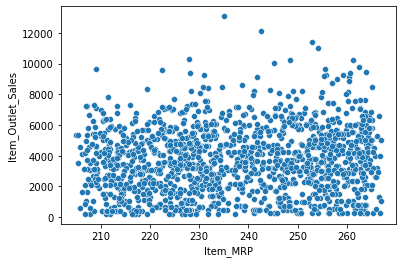

In [63]:
for cluster in [0,1,2,3]:
    train_data = train_df[train_df["cluster"]==cluster]
    sns.scatterplot(x=train_data["Item_MRP"],y=train_data["Item_Outlet_Sales"])
    plt.show()

<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

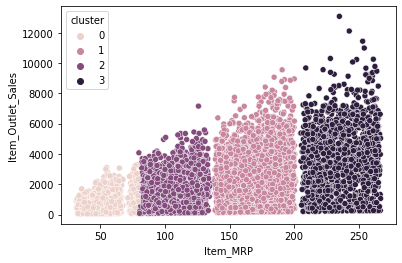

In [64]:
sns.scatterplot(x=train_df["Item_MRP"],y=train_df["Item_Outlet_Sales"],hue=train_df["cluster"])

In [ ]:
sns.scatterplot(x=tes_df["Item_MRP"],y=train_df["Item_Outlet_Sales"],hue=train_df["cluster"])